# Overview
Rather than trying to segment, we start off by making a model that simply tries to identify if any boat shows up in the image. 
For this model we can see roughly how it performs in the compititon by guessing the whole image (as an RLE) if any boat shows up (not a very smart startegy, but might provide some interesting results). 

## Beyond
The model could also be useful as a quick way (low resolution images) to screen through lots of images to see if they are likely to have a boat and if they are then run a much more expensive full-resolution U-Net on that sample

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations). It is slightly easier to keep track of parallel notebooks with different parameters if they are all at the beginning in a clear (machine readable format, see Kaggling with Kaggle (https://www.kaggle.com/kmader/kaggling-with-kaggle).

In [1]:
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# number of validation images to use
VALID_IMG_COUNT = 1000
# maximum number of training images
MAX_TRAIN_IMAGES = 15000 
BASE_MODEL='DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = 1e-4
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [14]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/datasets/ee285f-public/airbus_ship_detection/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

In [16]:
masks = pd.read_csv(os.path.join('/datasets/ee285f-public/airbus_ship_detection/',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
print(masks.head())

231723 masks found
192556
         ImageId                                      EncodedPixels  \
0  00003e153.jpg                                                NaN   
1  0001124c7.jpg                                                NaN   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   

                                                path  
0  /datasets/ee285f-public/airbus_ship_detection/...  
1  /datasets/ee285f-public/airbus_ship_detection/...  
2  /datasets/ee285f-public/airbus_ship_detection/...  
3  /datasets/ee285f-public/airbus_ship_detection/...  
4  /datasets/ee285f-public/airbus_ship_detection/...  


# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [27]:
from sklearn.model_selection import train_test_split
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
train_df=train_df.truncate(after=69)
valid_df = pd.merge(masks, valid_ids)
valid_df=valid_df.truncate(after=29)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

70 training masks
30 validation masks


### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

In [28]:
train_df = train_df.sample(min(MAX_TRAIN_IMAGES, train_df.shape[0])) # limit size of training set (otherwise it takes too long)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf97ce39b0>,
      dtype=object)

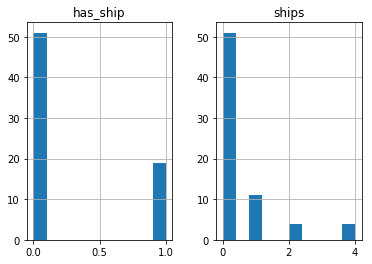

In [29]:
train_df[['ships', 'has_ship']].hist()

# Augment Data

In [37]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""A script for testing that TensorFlow is installed correctly on Windows.

The script will attempt to verify your TensorFlow installation, and print
suggestions for how to fix your installation.
"""

import ctypes
import imp
import sys

def main():
  try:
    import tensorflow as tf
    print("TensorFlow successfully installed.")
    if tf.test.is_built_with_cuda():
      print("The installed version of TensorFlow includes GPU support.")
    else:
      print("The installed version of TensorFlow does not include GPU support.")
    sys.exit(0)
  except ImportError:
    print("ERROR: Failed to import the TensorFlow module.")

  print("""
WARNING! This script is no longer maintained! 
=============================================

Since TensorFlow 1.4, the self-check has been integrated with TensorFlow itself,
and any missing DLLs will be reported when you execute the `import tensorflow`
statement. The error messages printed below refer to TensorFlow 1.3 and earlier,
and are inaccurate for later versions of TensorFlow.""")
    
  candidate_explanation = False

  python_version = sys.version_info.major, sys.version_info.minor
  print("\n- Python version is %d.%d." % python_version)
  if not (python_version == (3, 5) or python_version == (3, 6)):
    candidate_explanation = True
    print("- The official distribution of TensorFlow for Windows requires "
          "Python version 3.5 or 3.6.")
  
  try:
    _, pathname, _ = imp.find_module("tensorflow")
    print("\n- TensorFlow is installed at: %s" % pathname)
  except ImportError:
    candidate_explanation = False
    print("""
- No module named TensorFlow is installed in this Python environment. You may
  install it using the command `pip install tensorflow`.""")

  try:
    msvcp140 = ctypes.WinDLL("msvcp140.dll")
  except OSError:
    candidate_explanation = True
    print("""
- Could not load 'msvcp140.dll'. TensorFlow requires that this DLL be
  installed in a directory that is named in your %PATH% environment
  variable. You may install this DLL by downloading Microsoft Visual
  C++ 2015 Redistributable Update 3 from this URL:
  https://www.microsoft.com/en-us/download/details.aspx?id=53587""")

  try:
    cudart64_80 = ctypes.WinDLL("cudart64_80.dll")
  except OSError:
    candidate_explanation = True
    print("""
- Could not load 'cudart64_80.dll'. The GPU version of TensorFlow
  requires that this DLL be installed in a directory that is named in
  your %PATH% environment variable. Download and install CUDA 8.0 from
  this URL: https://developer.nvidia.com/cuda-toolkit""")

  try:
    nvcuda = ctypes.WinDLL("nvcuda.dll")
  except OSError:
    candidate_explanation = True
    print("""
- Could not load 'nvcuda.dll'. The GPU version of TensorFlow requires that
  this DLL be installed in a directory that is named in your %PATH%
  environment variable. Typically it is installed in 'C:\Windows\System32'.
  If it is not present, ensure that you have a CUDA-capable GPU with the
  correct driver installed.""")

  cudnn5_found = False
  try:
    cudnn5 = ctypes.WinDLL("cudnn64_5.dll")
    cudnn5_found = True
  except OSError:
    candidate_explanation = True
    print("""
- Could not load 'cudnn64_5.dll'. The GPU version of TensorFlow
  requires that this DLL be installed in a directory that is named in
  your %PATH% environment variable. Note that installing cuDNN is a
  separate step from installing CUDA, and it is often found in a
  different directory from the CUDA DLLs. You may install the
  necessary DLL by downloading cuDNN 5.1 from this URL:
  https://developer.nvidia.com/cudnn""")

  cudnn6_found = False
  try:
    cudnn = ctypes.WinDLL("cudnn64_6.dll")
    cudnn6_found = True
  except OSError:
    candidate_explanation = True

  if not cudnn5_found or not cudnn6_found:
    print()
    if not cudnn5_found and not cudnn6_found:
      print("- Could not find cuDNN.")
    elif not cudnn5_found:
      print("- Could not find cuDNN 5.1.")
    else:
      print("- Could not find cuDNN 6.")
      print("""
  The GPU version of TensorFlow requires that the correct cuDNN DLL be installed
  in a directory that is named in your %PATH% environment variable. Note that
  installing cuDNN is a separate step from installing CUDA, and it is often
  found in a different directory from the CUDA DLLs. The correct version of
  cuDNN depends on your version of TensorFlow:
  
  * TensorFlow 1.2.1 or earlier requires cuDNN 5.1. ('cudnn64_5.dll')
  * TensorFlow 1.3 or later requires cuDNN 6. ('cudnn64_6.dll')
    
  You may install the necessary DLL by downloading cuDNN from this URL:
  https://developer.nvidia.com/cudnn""")
    
  if not candidate_explanation:
    print("""
- All required DLLs appear to be present. Please open an issue on the
  TensorFlow GitHub page: https://github.com/tensorflow/tensorflow/issues""")

  sys.exit(-1)

if __name__ == "__main__":
  main()

ERROR: Failed to import the TensorFlow module.

WARNING! This script is no longer maintained! 

Since TensorFlow 1.4, the self-check has been integrated with TensorFlow itself,
and any missing DLLs will be reported when you execute the `import tensorflow`
statement. The error messages printed below refer to TensorFlow 1.3 and earlier,
and are inaccurate for later versions of TensorFlow.

- Python version is 3.6.

- TensorFlow is installed at: /opt/conda/lib/python3.6/site-packages/tensorflow


AttributeError: module 'ctypes' has no attribute 'WinDLL'

In [36]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/opt/conda/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/opt/conda/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [35]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/opt/conda/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/opt/conda/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [32]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [33]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

NameError: name 'core_idg' is not defined

In [34]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::RGB_FLIP], cmap='gray')
ax1.set_title('images')
ax2.plot(t_y)
ax2.set_title('ships')

NameError: name 'train_gen' is not defined

# Build a Model
We build the pre-trained top model and then use a global-max-pooling (we are trying to detect any ship in the image and thus max is better suited than averaging (which would tend to favor larger ships to smaller ones). 

In [ ]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, 
                                weights = 'imagenet')
base_pretrained_model.trainable = False

## Setup the Subsequent Layers
Here we setup the rest of the model which we will actually be training

In [ ]:
from keras import models, layers
from keras.optimizers import Adam
img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
pt_features = base_pretrained_model(img_noise)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
bn_features = layers.BatchNormalization()(pt_features)
feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
gmp_dr = layers.GlobalMaxPooling2D()(feature_dropout)
dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(gmp_dr))
out_layer = layers.Dense(1, activation = 'sigmoid')(dr_steps)

ship_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

ship_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])

ship_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('boat_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
train_gen.batch_size = BATCH_SIZE
ship_model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                      validation_data=(valid_x, valid_y), 
                      epochs=30, 
                      callbacks=callbacks_list,
                      workers=3)

In [ ]:
ship_model.load_weights(weight_path)
ship_model.save('full_ship_model.h5')

# Run the test data
We use the sample_submission file as the basis for loading and running the images.

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
submission_df = pd.read_csv('../input/sample_submission_v2.csv')
submission_df['path'] = submission_df['ImageId'].map(lambda x: os.path.join(test_image_dir, x))

# Setup Test Data Generator
We use the same generator as before to read and preprocess images

In [ ]:
test_gen = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)

In [ ]:
fig, m_axs = plt.subplots(3, 2, figsize = (20, 30))
for (ax1, ax2), (t_x, c_img_names) in zip(m_axs, test_gen):
    t_y = ship_model.predict(t_x)
    t_stack = ((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, :, ::RGB_FLIP]
    ax1.imshow(montage_rgb(t_stack))
    ax1.set_title('images')
    alpha_stack = np.tile(np.expand_dims(np.expand_dims(t_y, -1), -1), [1, t_stack.shape[1], t_stack.shape[2], 1])
    rgba_stack = np.concatenate([t_stack, alpha_stack], -1)
    ax2.imshow(montage_rgb(rgba_stack))
    ax2.set_title('ships')
fig.savefig('test_predictions.png')

# Prepare Submission
Process all images (batchwise) and keep the score at the end

In [ ]:
BATCH_SIZE = BATCH_SIZE*2 # we can use larger batches for inference
test_gen = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)

In [ ]:
from tqdm import tqdm_notebook
all_scores = dict()
for _, (t_x, t_names) in zip(tqdm_notebook(range(test_gen.n//BATCH_SIZE+1)),
                            test_gen):
    t_y = ship_model.predict(t_x)[:, 0]
    for c_id, c_score in zip(t_names, t_y):
        all_scores[c_id] = c_score

# Show the Scores
Here we see the scores and we have to decide about a cut-off for counting an image as ship or not. We can be lazy and pick 0.5 but some more rigorous cross-validation would definitely improve this process.

In [ ]:
submission_df['score'] = submission_df['ImageId'].map(lambda x: all_scores.get(x, 0))
submission_df['score'].hist()

# Make the RLE data if there is a ship
Here we make the RLE data for a positive image (assume every pixel is ship)

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# empty image
zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [ ]:
# add the whole image if it is above the threshold
submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)

In [ ]:
out_df = submission_df[['ImageId', 'EncodedPixels']]
out_df.to_csv('submission.csv', index=False)
out_df.head(20)